In [90]:
from pyrosm import OSM
from pyrosm import get_data
import pandas as pd
import h3.api.numpy_int as h3 
import shapely

In [65]:
H3_RES = 12
h3_tags = dict()

def coord_to_h3(lat, lon, category):
    h3_index = h3.geo_to_h3(lat, lon, H3_RES)
    try:
        h3_tags[h3_index].append(category)
    except:
        h3_tags[h3_index]=[category]

    return h3_index



In [5]:
osm = OSM("copenhagen_test.pbf")

In [6]:
# idea: EVERYONE can use it and live a healthy life with this as their only source
#check: doctors, clinic, health_food, food
#essential filter will be the least restrictive!

essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy"],
    "leisure":["park"],
    "sport":True
    }

# n minute city must satisfy the following expression based on
# the existence of certain tags within n minutes:
'''
n_minute_requirements = \
    # category_name = (boolean with all relevant osm tags)
    supermarket = (supermarket or greengrocer or wholesale or grocery) and \
    pharmacy = (pharmacy or medical_supply) and\
    park = (park) and\
    dentist = (dentist) and \
    doctor = (clinic or doctor or doctors) and \
    sport = any(sport)
'''
# easy use case which is debateably also essential
education_filter = {"amenity":["school"]}

In [7]:
pois = osm.get_pois(custom_filter=essential_filter)


/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [66]:
# some tags don't have headers, find manually in tags
def tag_conditions(tags, healthcare_list):
    # search for healthcare tag substring, return match
    s = [s for s in healthcare_list if s in tags]
    if s:
        return s[0]
    elif "sport" in tags:
        return "sport" 
    else:
        return None

osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor"
}

def osm_to_manual_category(tag):
    # faster than searching keys to try, except
    try:
        return osm_tag_mapping[tag]
    except:
        return tag


pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])
pois["poi_type"] = pois["poi_type"].fillna(pois["leisure"])

# some tags don't have a poi_type
pois['tags'] = pois['tags'].astype(str)
pois['no_header'] = pois.apply(lambda x: tag_conditions(x.tags, essential_filter['healthcare']), axis=1)
pois["poi_type"] = pois["poi_type"].fillna(pois["no_header"])

# convert to n minute city category
pois['category'] = pois["poi_type"].apply(osm_to_manual_category)

# convert to h3
pois['h3_index'] = pois.apply(lambda x: coord_to_h3(x.lat, x.lon, x.category), axis=1)

In [188]:
pois["geom_type"] = pois.apply(lambda x: x.geometry.geom_type, axis=1)
pois['geom_type'].unique()

array(['Point', 'Polygon', 'MultiLineString', 'LineString',
       'MultiPolygon'], dtype=object)

In [205]:
def all_shapley_geo_to_h3(obj, geom_type, H3_RES):
    if geom_type=='MultiPolygon':
        # this will break in a different version of shapley, use this instead of iterating polys in multipoly: 
        # multi_poly.coords
        return [ind for p in obj for ind in h3.polyfill(shapely.geometry.mapping(p), H3_RES)] # loop through polys and flatten
    elif geom_type=='Polygon':
        return h3.polyfill(shapely.geometry.mapping(obj), H3_RES)
    elif geom_type=='MultiLineString':
        pass
    elif geom_type=='LineString':
        pass
    elif geom_type=='Point':
        pass
        #h3_index = h3.geo_to_h3(lat, lon, H3_RES)
    else:
        print("unimplemented polygon")
    
h3.polyfill(shapely.geometry.mapping(polygon), H3_RES)

array([632257197255508991, 632257197255625215, 632257197255623679,
       632257197255518719, 632257197267277823, 632257197255517183,
       632257197267261951, 632257197267276287, 632257197255515647,
       632257197255649279, 632257197267260415, 632257197255647743,
       632257197255509503, 632257197267399167, 632257197255519231,
       632257197255636991, 632257197267278335, 632257197267262463,
       632257197255635455, 632257197267276799, 632257197255632383,
       632257197255511551, 632257197255510015, 632257197267388415,
       632257197255508479, 632257197267399679, 632257197255637503,
       632257197267278847, 632257197267262975, 632257197255516671,
       632257197267261439, 632257197255634431, 632257197255648767,
       632257197267259903, 632257197255632895, 632257197255631359],
      dtype=uint64)

In [209]:
h3.h3_line((1,2),(3,4))

TypeError: an integer is required

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_31585/2485398657.py:1: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  [ind for p in multi_poly for ind in h3.polyfill(shapely.geometry.mapping(p), H3_RES)]


[632257196994939903,
 632257202107268095,
 632257196997171711,
 632257196995154943,
 632257197058819583,
 632257196995056127,
 632257202107384319,
 632257197059249663,
 632257197058935807,
 632257196995172351,
 632257197059150847,
 632257196994858495,
 632257202107401727,
 632257197059168255,
 632257197058854399,
 632257197059116031,
 632257196994875903,
 632257197059284479,
 632257197058871807,
 632257196994922495,
 632257196994893311,
 632257197059086847,
 632257196995323391,
 632257197059301887,
 632257197058988031,
 632257196994910719,
 632257197059104255,
 632257196995125759,
 632257196995340799,
 632257196994928127,
 632257202107256319,
 632257197058906623,
 632257196995143167,
 632257197059121663,
 632257196994945535,
 632257202107273727,
 632257197059139071,
 632257196995160575,
 632257197058825215,
 632257196995061759,
 632257197059255295,
 632257196994219007,
 632257197059156479,
 632257196995120127,
 632257197059098623,
 632257196995177983,
 632257196994864127,
 632257196994

In [191]:
polygon.exterior.coords.xy

(array('d', [12.4194279, 12.4191228, 12.4188635, 12.4188467, 12.419132, 12.4188925, 12.4187567, 12.4181893, 12.4181085, 12.41757, 12.4184639, 12.4185951, 12.4193791, 12.4194279]),
 array('d', [55.678712, 55.6787696, 55.6789098, 55.6791919, 55.679498, 55.6796081, 55.6796365, 55.6796167, 55.6795909, 55.6790637, 55.6787619, 55.6788719, 55.678626, 55.678712]))

In [198]:
polygon

'Polygon'

In [196]:
polygon = pois.loc[2580, 'geometry']
multi_poly = pois.loc[2578, 'geometry']
# function name doesnt exist
# h3.polygon_to_cells(polygon, H3_RES, geo_json_conformant=False)

In [164]:
h3_list = h3.polyfill(shapely.geometry.mapping(polygon), 13)

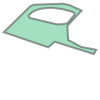

In [165]:
polygon

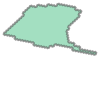

In [166]:
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

def h3_list_to_multi_poly(h3_list):
    h3_polygon = h3.h3_set_to_multi_polygon(h3_list)
    # for some reason you can't go straight to multiploly ////:
    return MultiPolygon([Polygon(p[0]) for p in h3_polygon])

h3_list_to_multi_poly(h3_list)

In [68]:
pois['h3_index'].value_counts()

0                     1718
631049684455625215       3
631049683855035391       3
631049688271755263       2
631049690177703423       2
                      ... 
631049684130682879       1
631049688132016127       1
631049684425297407       1
631049684199544831       1
631049688233911807       1
Name: h3_index, Length: 842, dtype: int64

In [ ]:
pois['']

In [56]:
pois

,id,changeset,lon,timestamp,tags,version,lat,email,name,opening_hours,...,leisure,outdoor_seating,geometry,osm_type,building,building:levels,landuse,poi_type,no_header,category
0,272860527,0.0,12.485415,0,"{""branch"":""Valby Vigerslevvej"",""brand"":""Netto""...",0,55.655972,None,Netto,Mo-Su 08:00-22:00,...,None,None,POINT (12.48542 55.65597),node,NaN,NaN,NaN,supermarket,None,supermarket
1,272860703,0.0,12.501348,0,"{""branch"":""Valby Gammel K\u00F8ge Landevej"",""b...",0,55.643234,None,Netto,Mo-Su 08:00-22:00,...,None,None,POINT (12.50135 55.64323),node,NaN,NaN,NaN,supermarket,None,supermarket
2,274078612,0.0,12.484646,0,"{""club"":""sport"",""sport"":""soccer""}",0,55.623829,None,Boldklubben Friheden,None,...,None,None,POINT (12.48465 55.62383),node,NaN,NaN,NaN,sport,sport,sport
3,279715915,0.0,12.536201,0,None,0,55.685993,None,California Frugt & Grønt,None,...,None,None,POINT (12.53620 55.68599),node,NaN,NaN,NaN,greengrocer,None,supermarket
4,281569512,0.0,12.483717,0,"{""branch"":""Frihedens Butikscenter"",""brand"":""F\...",0,55.626831,None,Føtex,None,...,None,None,POINT (12.48372 55.62683),node,NaN,NaN,NaN,supermarket,None,supermarket
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576,15449385718,0.0,NaN,0,"{""type"":""multipolygon""}",-1,NaN,NaN,None,NaN,...,park,NaN,"POLYGON ((12.56454 55.72844, 12.56457 55.72843...",relation,None,NaN,None,park,None,park
2577,16276649895,0.0,NaN,0,"{""type"":""multipolygon""}",-1,NaN,NaN,None,NaN,...,park,NaN,"MULTIPOLYGON (((12.53136 55.71694, 12.53164 55...",relation,None,NaN,None,park,None,park
2578,17321954361,0.0,NaN,0,"{""type"":""multipolygon""}",-1,NaN,NaN,Kagsåparken,NaN,...,park,NaN,"MULTIPOLYGON (((12.45036 55.73215, 12.45132 55...",relation,None,NaN,None,park,None,park
2579,17359127160,0.0,NaN,0,"{""type"":""multipolygon""}",-1,NaN,NaN,None,NaN,...,park,NaN,"POLYGON ((12.45212 55.66410, 12.45287 55.66409...",relation,None,NaN,None,park,None,park


In [57]:
pois.poi_type.unique()

array(['supermarket', 'sport', 'greengrocer', 'clinic', 'pharmacy',
       'bowling_alley', 'doctors', 'dentist', 'fitness_centre',
       'sports_centre', 'bar', 'pub', 'climbing_wall', 'pitch',
       'swimming_pool', 'stadium', 'fitness_station', 'medical_supply',
       'sports', 'dojo', 'cafe', 'wholesale', 'park', 'community_centre',
       'gambling', 'grocery', 'fast_food', 'track'], dtype=object)

In [58]:
pois[pois['poi_type'].str.contains("healthcare")]

,id,changeset,lon,timestamp,tags,version,lat,email,name,opening_hours,...,leisure,outdoor_seating,geometry,osm_type,building,building:levels,landuse,poi_type,no_header,category


In [69]:
pois

,id,lon,lat,changeset,timestamp,tags,version,email,name,opening_hours,...,wikipedia,organic,second_hand,shop,wholesale,geometry,osm_type,building,building:levels,landuse
0,272860527,12.485415,55.655972,0.0,0,"{""branch"":""Valby Vigerslevvej"",""brand"":""Netto""...",0,None,Netto,Mo-Su 08:00-22:00,...,None,None,None,supermarket,None,POINT (12.48542 55.65597),node,NaN,NaN,NaN
1,272860703,12.501348,55.643234,0.0,0,"{""branch"":""Valby Gammel K\u00F8ge Landevej"",""b...",0,None,Netto,Mo-Su 08:00-22:00,...,None,None,None,supermarket,None,POINT (12.50135 55.64323),node,NaN,NaN,NaN
2,274078612,12.484646,55.623829,0.0,0,"{""club"":""sport"",""sport"":""soccer""}",0,None,Boldklubben Friheden,None,...,None,None,None,None,None,POINT (12.48465 55.62383),node,NaN,NaN,NaN
3,279715915,12.536201,55.685993,0.0,0,None,0,None,California Frugt & Grønt,None,...,None,None,None,greengrocer,None,POINT (12.53620 55.68599),node,NaN,NaN,NaN
4,281569512,12.483717,55.626831,0.0,0,"{""branch"":""Frihedens Butikscenter"",""brand"":""F\...",0,None,Føtex,None,...,None,None,None,supermarket,None,POINT (12.48372 55.62683),node,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,12024564812,NaN,NaN,0.0,0,"{""leisure"":""track"",""sport"":""athletics"",""type"":...",-1,NaN,NaN,NaN,...,None,None,None,None,None,"POLYGON ((12.53684 55.65767, 12.53691 55.65766...",relation,None,NaN,None
922,15211881204,NaN,NaN,0.0,0,"{""leisure"":""track"",""sport"":""athletics"",""type"":...",-1,NaN,NaN,NaN,...,None,None,None,None,None,"POLYGON ((12.37142 55.62853, 12.37149 55.62857...",relation,None,NaN,None
923,15222662633,NaN,NaN,0.0,0,"{""leisure"":""track"",""sport"":""athletics"",""type"":...",-1,NaN,NaN,NaN,...,None,None,None,None,None,"POLYGON ((12.37190 55.61907, 12.37204 55.61913...",relation,None,NaN,None
924,15233444082,NaN,NaN,0.0,0,"{""leisure"":""track"",""sport"":""athletics"",""type"":...",-1,NaN,NaN,NaN,...,None,None,None,None,None,"POLYGON ((12.45668 55.66838, 12.45688 55.66840...",relation,None,NaN,None


In [ ]:
# misc filters
'''
check: marketplace, childcare, studio, food

work_filter = {"amenity":["coworking_space"]}

elderly_care = {"amenity":["nursing_home","retirement_home"]}

healthcare_filter = {"amenity": ["hospital","dentist","doctors","pharmacy","clinic"]}

sport_filter = {"amenity": ["climbing_wall","dojo"]}

culture_filter = {"amenity":["cinema","theatre","events_venue","arts_centre","place_of_worship","library","music_venue","community_centre","dancing_school","social_facility","gallery","social_centre","conference_centre","public_bath"]}

social_filter = {"amenity":["pub","bar","nightclub","cafe","internet_cafe"]}

food_filter = {"amenity":["restaurant","kitchen","food_court"],"shop":["supermarket","greengrocer","confectionery"]}

education_filter = {"amenity":["school","kindergarten","language_school"]}

'''

In [80]:
# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
# https://wiki.openstreetmap.org/wiki/Map_features
# there is overlap, basically no need to use building tag
custom_filter = {"amenity": True, "shop": True, "healthcare": True, "leisure": True, "sport": True, "building": True}
custom_filter = {"amenity": ["doctors"]}
#custom_filter = {"amenity":["clinic"]}

pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
#pois["poi_type"] = pois["amenity"]
#pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

/Users/petermehler/opt/anaconda3/envs/pyrosm_env/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [81]:
pois['tags'].value_counts()[0:10]

{"healthcare":"doctor"}                                                                                                                                                   7
{"wheelchair":"yes"}                                                                                                                                                      1
{"healthcare":"doctor","wheelchair":"yes"}                                                                                                                                1
{"healthcare":"doctor","wheelchair":"no"}                                                                                                                                 1
{"check_date:opening_hours":"2023-01-07","contact:phone":"+4535853219","contact:website":"https://www.besoeglaegen.dk","opening_hours:signed":"no","wheelchair":"yes"}    1
{"healthcare":"psychotherapist","healthcare:speciality":"psychiatry"}                                                                       

In [82]:
pois['name']

0                                           None
1                                           None
2                                Læge Jørgen Rem
3                          Ørestadens Lægeklinik
4                                 Sellmer Klinik
5                                    Anders Munk
6                                           None
7                                    Lægehjørnet
8                Centrumterapi v/ Hanne Pedersen
9                           Lægehuset Æblegården
10                  Øjenlægerne Glostrup Centrum
11                                 Valby Hudlæge
12                         Kanalbyens Lægeklinik
13                      Hudlægerne Amagerbrogade
14                      Lægerne Amagerbrogade 17
15    Øre-, næse- og halsklinikken ved Kultorvet
16                        Sundhedshuset Brønshøj
17                              Læge Amneh Hawwa
18                             Lægeklinikken IOM
19                    Hudklinikken Frederiksberg
20                  

In [60]:
pois[~pois['amenity'].isna()]

,id,lon,lat,changeset,timestamp,tags,version,name,operator,ref,...,building:use,craft,height,internet_access,landuse,office,shop,source,start_date,wikipedia
129,25109996,NaN,NaN,NaN,0,"{""internet_access:fee"":""no"",""ref:isil"":""DK-714...",-1,Frederiksberg Hovedbiblioteket,None,None,...,None,None,None,None,None,None,None,Bing,None,None
155,25421936,NaN,NaN,NaN,0,"{""wheelchair"":""no"",""wikidata"":""Q2711052""}",-1,Palads Biograferne,None,None,...,None,None,None,None,None,None,None,None,None,da:Palads Teatret (København)
157,25451190,NaN,NaN,NaN,0,"{""alt_name:es"":""Vor_Frue_Kirke"",""architect"":""C...",-1,Vor Frue Kirke,None,None,...,None,None,None,wlan,None,None,None,Mapillary,1829,da:Vor Frue Kirke (København)
158,25451276,NaN,NaN,NaN,0,"{""ref:isil"":""DK-710100"",""wheelchair"":""yes"",""wi...",-1,Hovedbiblioteket,None,None,...,None,None,None,wlan,None,None,None,None,None,None
174,25466133,NaN,NaN,NaN,0,"{""fvst:name"":""DET KONGELIGE TEATER OG KAPEL- A...",-1,Det Kongelige Teater,None,None,...,None,None,None,None,None,None,None,None,None,da:Det Kongelige Teater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195678,17633276328,NaN,NaN,0.0,0,"{""denomination"":""roman_catholic"",""religion"":""c...",-1,Sankt Nikolaj Kirke,None,None,...,NaN,NaN,None,None,NaN,None,None,None,None,da:Sankt Nikolaj Kirke (Hvidovre)
195685,18379184851,NaN,NaN,0.0,0,"{""type"":""multipolygon"",""wikidata"":""Q28167854""}",-1,Guldberg Skole,None,None,...,NaN,NaN,None,None,NaN,None,None,None,None,None
195689,18556987983,NaN,NaN,0.0,0,"{""type"":""building""}",-1,None,None,None,...,NaN,NaN,None,None,NaN,None,None,None,None,None
195690,18620635989,NaN,NaN,0.0,0,"{""contact:email"":""skolenvedsoerne@frederiksber...",-1,Skolen ved Søerne,None,None,...,NaN,NaN,None,None,NaN,None,None,None,None,None


In [71]:
pois.columns

Index(['id', 'lon', 'lat', 'changeset', 'timestamp', 'tags', 'version',
       'email', 'name', 'opening_hours', 'operator', 'phone', 'ref', 'url',
       'website', 'fitness_station', 'leisure', 'outdoor_seating',
       'playground', 'geometry', 'osm_type', 'picnic_table', 'swimming_pool'],
      dtype='object')

In [ ]:
pois.query("poi_type==school")

In [7]:
pois[pois['poi_type']=="school"]

243                                                   None
253                                                   None
605                               {"wheelchair":"limited"}
651                                                   None
677                                                   None
                               ...                        
29914                              {"type":"multipolygon"}
29916       {"type":"multipolygon","wikidata":"Q12306265"}
29925                              {"type":"multipolygon"}
29929       {"type":"multipolygon","wikidata":"Q28167854"}
29932    {"contact:email":"skolenvedsoerne@frederiksber...
Name: tags, Length: 271, dtype: object

In [18]:
pd.DataFrame(pois['poi_type'].value_counts()).to_csv("list_of_poi_types.csv")

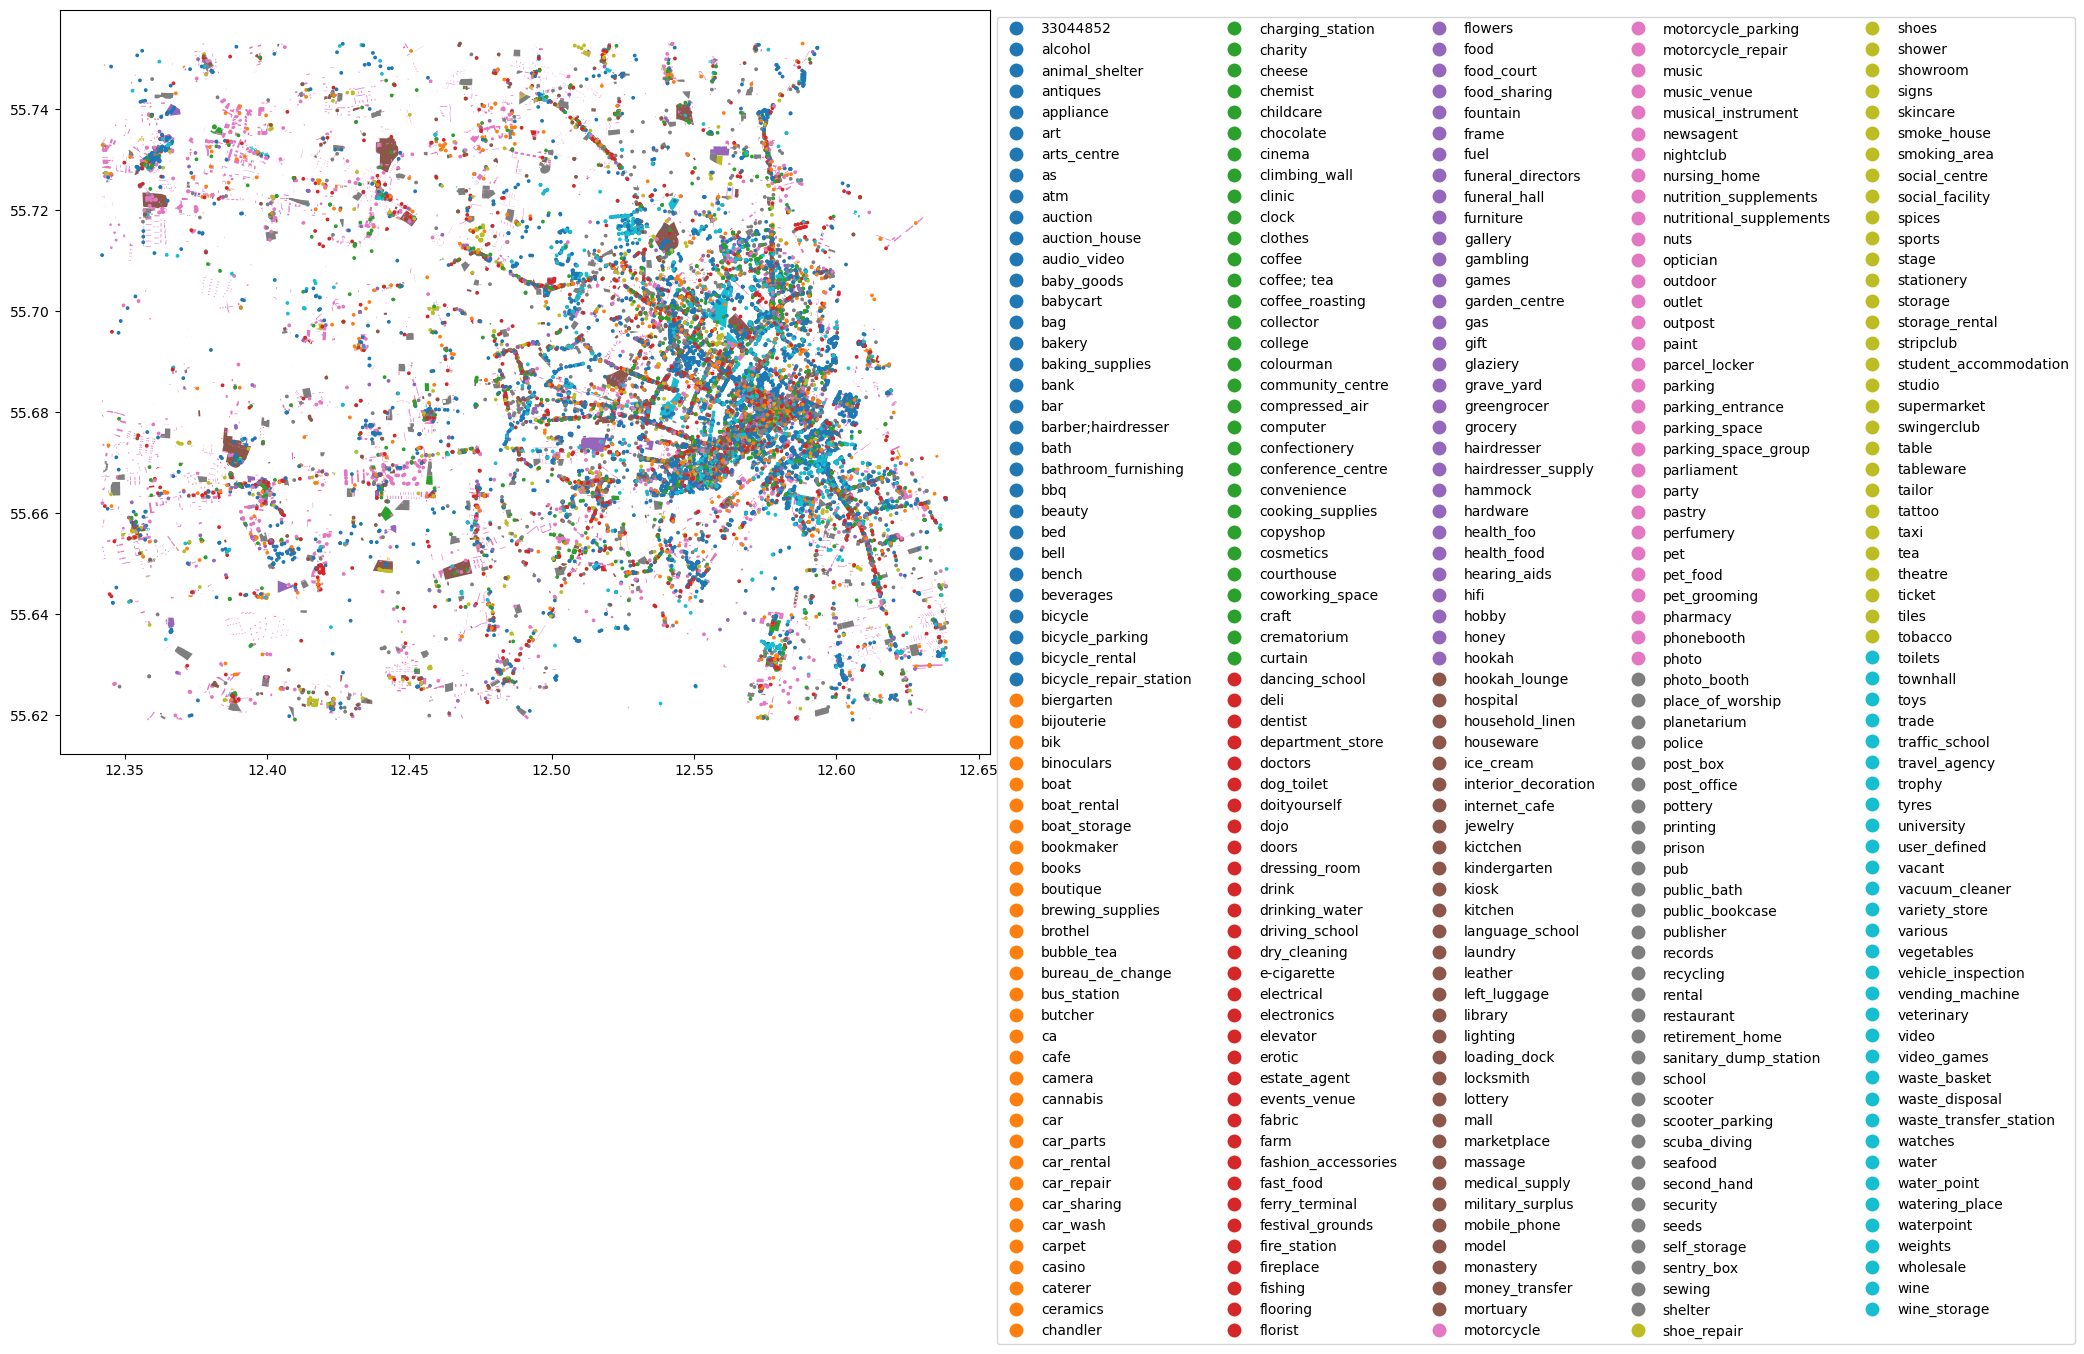

In [26]:
# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))